# Slanted Edge method
## In this notebook I wil show how to use an image of a slanted edge to characterize the Modulation Transfer Function of an optical system.

Source: https://fakahil.github.io/solo/how-to-use-a-tilted-edge-in-an-imaging-target-to-characterize-the-mtf-of-the-telescope/index.html

The basics of this method is to find a slightly tilted edge in a target which you image with your optical system. 

The Edge Profile Function (EPF) will inform you on the change of contrast across this edge (by computing the gradient along the edge,  which we will call the Line Transfer Function, LTF). 

The Fourier Transform of the LTF will be the 1D Modulation Transfer Function (MTF). The reason we take a tilted edge is to have more sample data points after projecting them to the direction normal to the edge for a precise computation of the MTF.

Method
1. Average and do background subtraction
2. Extract locations of inflection points (pixel coordinates)
3. Fit complementary error function (1-erf)

In [3]:
import numpy as np
from scipy import special
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import scipy
import math
from numpy import fft
from numpy.fft import fft, ifft, fftshift, ifftshift
from scipy.optimize import curve_fit
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
# lowess documentation https://www.statsmodels.org/dev/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html

In [4]:
## Define Erfc function
def Erfc(x,sigma,a):
 y = a*special.erfc(-x/(sigma*np.sqrt(2)))
 return y

In [5]:
# Compute the first derivative

def process_limb(x,y):
    frac = 1/30.
    d1 = np.diff(y)/np.diff(x)
    xd1 = 0.5*(x[:-1]+x[1:])
    xd2 = 0.5*(xd1[:-1]+xd1[1:])
    d2 = np.diff(d1)/np.diff(xd1)
    w = lowess(d1, xd1, frac)
    s_x, s_y = w[:,0], w[:,1]
    #ind = np.where(d1==d1.max())
    #print  x[ind]
    ind = np.where(s_y==s_y.max())
    #temp =  x[ind] 
    temp = s_x[ind] 
    x = (x-  temp)#x[ind]
    # print(temp)
    # plt.plot(xd1,d1)
    # plt.plot(s_x,s_y)
    # plt.axvline(x=temp)
    # plt.show()
    return temp,x#, y


In [164]:
def detect_edge(x,y, debug=False):
    """ Determine the inflection point of a 1D array
        using local gradient methods. 

    Args:
        x (1D np.array): horizontal coordinate
        y (1D np.array): pixel value

    Returns:
        xd1[ind], y[ind]: location and pixel value at that location
    """
    # frac = 1/30.
    # take element-wise differences
    # get instantaneous rate of change
    d1 = np.diff(y)/np.diff(x)
    # derivative position is at midpoints
    xd1 = 0.5*(x[:-1]+x[1:])

    # apply smoothing (20/2/2023 was found to give slightly incorrect estimates)
    # w = lowess(d1, xd1, frac)
    # s_x, s_y = w[:,0], w[:,1]
    # ind = np.where(s_y==s_y.max())
    
    ind = np.argmax(d1)
    
    if debug:
        plt.title('Edge detection output')
        plt.plot(x,y, label='edge')
        plt.plot(xd1, d1, label='instantaneous rate of change')
        # plt.plot(s_x, s_y, 'instantaneous rate of change')
        plt.axvline(x[ind])
        plt.legend()
    # plt.show()
    # plt.clf()
    #print ind
    # s_x[ind],y[ind]
    return xd1[ind], y[ind]

In [137]:
def merge(x,y):
    x = np.concatenate(x)
    y = np.concatenate(y)
    return x,y

In [138]:
def sort(x,y):
    points = zip(x,y)

    points.sort()
    xx = np.array([p[0] for p in points])
    yy = np.array([p[1] for p in points])
    return xx,yy

In [139]:
def compute_lsf(x,y):
    d1 = np.abs(np.diff(y)/np.diff(x))
    xd1 = 0.5*(x[:-1]+x[1:])
    return xd1, d1
    

In [140]:
def compute_mtf(lsf_x,lsf_y):
    lsf = fftshift(lsf_y)
    mtf = fft(lsf)
    f  = (lsf_x.size) * np.arange(0, lsf_x.size, step = 1)
    
    #freq = np.linspace(0,N*0.5,size/2)
    #freq = np.arange(0,N*0.5,1./(size))
    mtf= np.abs(mtf)
    mtf = mtf/mtf.max()
    # plt.plot(f[f <= 1 / 2], mtf[f <= 1 / 2])
    # plt.show()
    #return freq, mtf[0:size/2]

In [141]:
def Lowess(y,x,frac):
    w = sm.nonparametric.lowess(y, x, frac)
    s_x, s_y = w[:,0], w[:,1]
    return s_x,s_y

In [142]:
# path = '/home/fatima/Desktop/solar_orbiter_project/codes/targets/MTF/'
# edge = pyfits.getdata(path+'Edge_0_FS_3.fits')
theta = 3

from skimage import io
# edge = io.imread("2022-12-15 edge in water f6.tif")[700:800, 500:600]

# Image averaging and background subtraction goes here

In [143]:
from skimage import io
import cv2

In [144]:
def load_stack(path, x_min=400, x_max=700, y_min=300, y_max=600, show=False):
    imgs = io.imread(path+'/MMStack_Pos0.ome.tif')[:, x_min:x_max, y_min:y_max]
    if show:
        plt.imshow(imgs[0], cmap="gray")
        plt.title(f'Image 1 of {len(imgs)}')
        plt.show()
    print(f"Loaded stack of {imgs.shape[0]} images, dimensions {imgs.shape[1:]}")
    return imgs

In [145]:
def average_stack(imgs, im_per_pos=5, show=False):
    # adapted from: https://stackoverflow.com/a/69721142
    image_sets = imgs.reshape((len(imgs)//im_per_pos, im_per_pos, imgs.shape[1], imgs.shape[2]))
    avg_stack = np.mean(image_sets, axis=1)
    if show:
        plt.imshow(avg_stack[0], cmap="gray")
        plt.title(f'Image 1 of {len(avg_stack)}')
        plt.show()
    print(f"Averaged original stack of {len(imgs)} down to {len(avg_stack)}.")
    return avg_stack

In [146]:
def remove_background(imgs, bg_light, bg_dark, show=False):
    # adapted from: https://stackoverflow.com/a/73082666
    imgs_minus_bg = np.clip(imgs - bg_dark, 0, imgs.max())
    light_minus_bg = np.clip(bg_light - bg_dark, 0, bg_light.max())
    divided = np.clip(imgs_minus_bg / light_minus_bg, 0, imgs_minus_bg.max())
    if show:
        f, axes = plt.subplots(2, 2, figsize=(10, 10))
        axes[0][0].imshow(imgs[0], cmap="gray")
        axes[0][0].set_title(f"imgs, 1 of {len(imgs)}")
        axes[0][1].imshow(imgs_minus_bg[0], cmap="gray")
        axes[0][1].set_title(f"imgs_minus_bg, 1 of {len(imgs_minus_bg)}")
        axes[1][0].imshow(light_minus_bg[0], cmap="gray")
        axes[1][0].set_title(f"light_minus_bg, 1 of {len(light_minus_bg)}")
        axes[1][1].imshow(divided[0], cmap="gray")
        axes[1][1].set_title(f"divided, 1 of {len(divided)}")
        plt.tight_layout()
        plt.show()
    print(f"Removed background and divided illumination from {len(divided)} images.")
    return divided

In [147]:
data_dir = '../../data_store/'
bg_dir = data_dir + '/2023-01-17 background images'
img_dir = data_dir + '/2023-01-17 edge redone'

img_path = img_dir + '/2023-01-17 edge in water f-a'
imgs =  load_stack(img_path)

avg_stack = average_stack(imgs)

bg_light_path = bg_dir + '/2023-01-17 bg light f-a'
bg_dark_path = bg_dir + '/2023-01-17 bg dark f-a'
bg_light = average_stack(load_stack(bg_light_path))
bg_dark = average_stack(load_stack(bg_dark_path))

divided = remove_background(avg_stack, bg_light, bg_dark)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/kenton/Library/CloudStorage/OneDrive-ImperialCollegeLondon/University/Physics/Year 4/project/data_store/2023-01-17 edge redone/2023-01-17 edge in water f-a/MMStack_Pos0.ome.tif'

In [196]:
edge = io.imread('../../OPT Shared files/1_Data/2023-02-15 edge depth sweep green/2023-02-15 fa/MMStack_Pos0.ome.tif')[125//2, 200:]

# Resume existing code

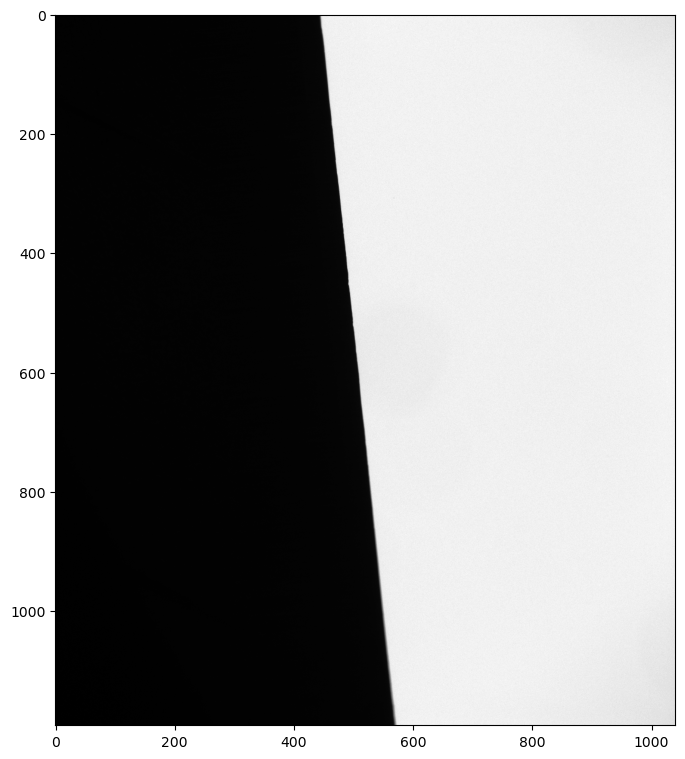

In [197]:
plt.figure(figsize=(8,10))
plt.imshow(edge,cmap='gray')

Compute the edge angle by plotting the all edge profiles along the image and computing their inflection point.

By looking at the location of where the inflection point varies, we can find the tilt angle.

Text(0.5, 0, 'Horizontal coordinate')

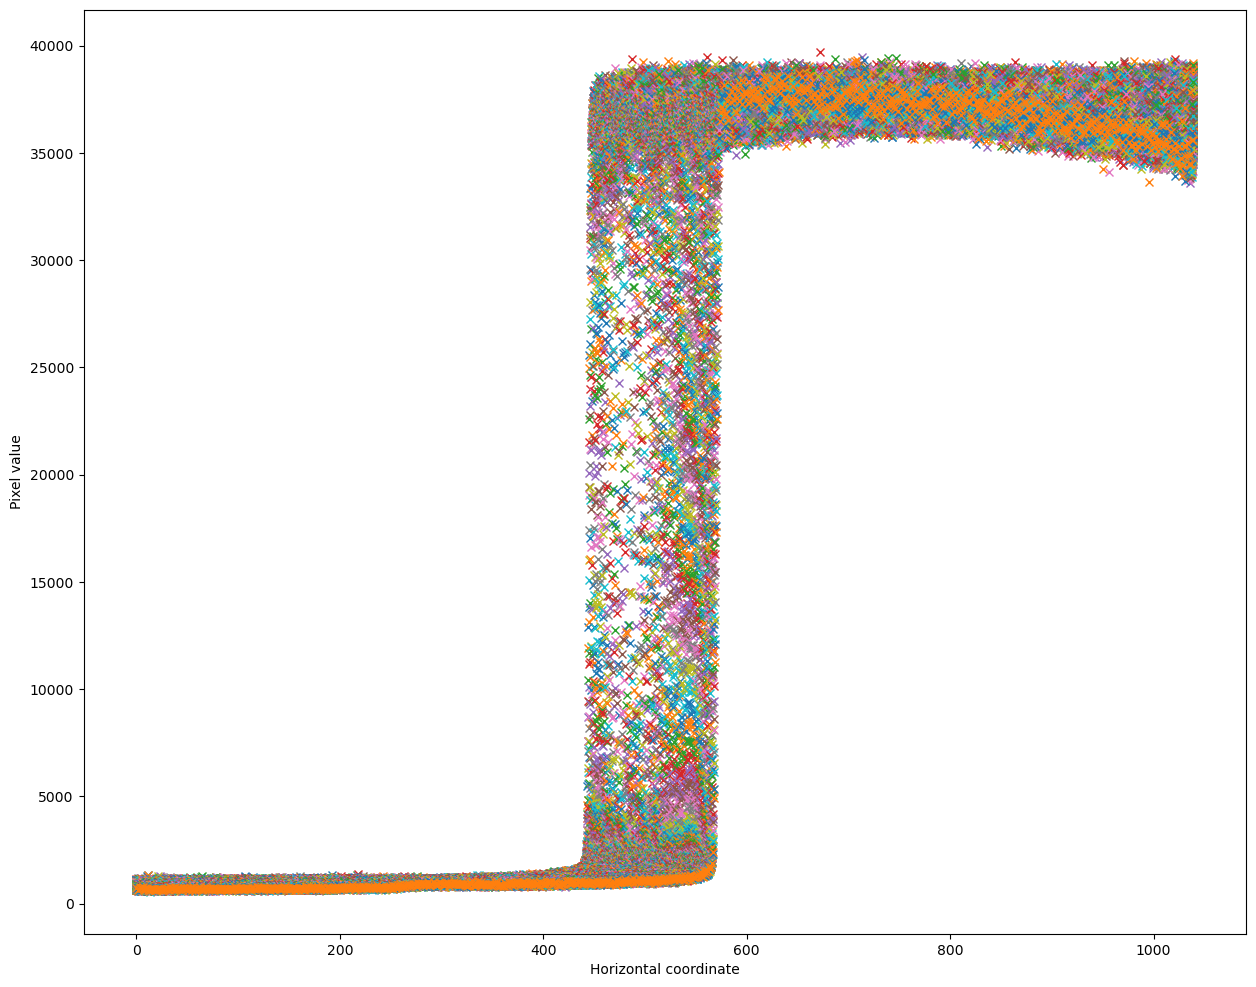

In [198]:
rows = np.arange(edge.shape[0]) 
n_rows = len(rows) 
i = 0
profile = np.zeros((n_rows,edge.shape[1]))
for row in rows:
    profile[i] = edge[row,:]
    i = i+1

plt.figure(figsize=(15,12))
for row in range(n_rows):
  plt.plot(profile[row],'x')
plt.ylabel('Pixel value')
plt.xlabel('Horizontal coordinate')

In [199]:
coords_x = []
coords_y = []
x = np.arange(edge.shape[1])

for row in range(n_rows):
  x_e, y_e = detect_edge(x,profile[row], debug=False)
  # print(type(y_e))
  coords_x.append(x_e)
  coords_y.append(row)
  # plt.xlim(400,600)
  # plt.show()
  # plt.clf()

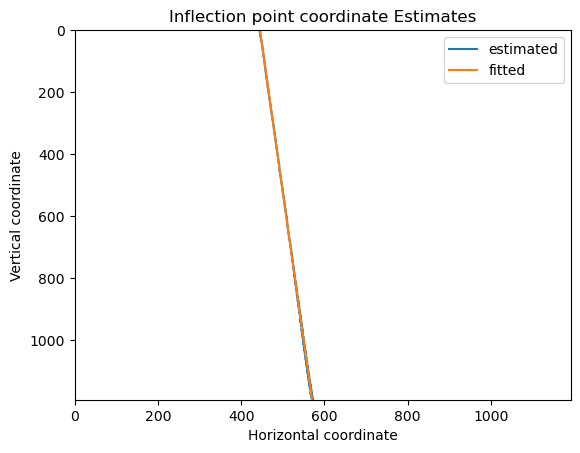

In [235]:
# Not sure why the code decides to sort the values? I removed this.
x = coords_x #sorted(coords_x)
y = coords_y #sorted(coords_y)

plt.title('Inflection point coordinate Estimates')
plt.plot(x, y, label = 'estimated')
plt.xlabel('Horizontal coordinate')
plt.ylabel('Vertical coordinate')


from scipy.optimize import curve_fit
x = np.asarray(x)
y = np.asarray(y)

def f(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B
p0 = [1,1]
popt, pcov = scipy.optimize.curve_fit(f,x,y,p0)#bin_edges[:-1],bin_means) # 

plt.plot(x, f(x, *popt), label='fitted')
plt.ylim(len(x),0)
plt.xlim(0, len(y))
plt.legend()

In [236]:
angle =np.rad2deg(np.arctan(popt[0])) #np.rad2deg(np.arctan2(ynew[-1] - ynew[0], xnew[-1] - xnew[0]))
print('the angle is', 90-angle, 'deg')

the angle is 5.998479408681504 deg


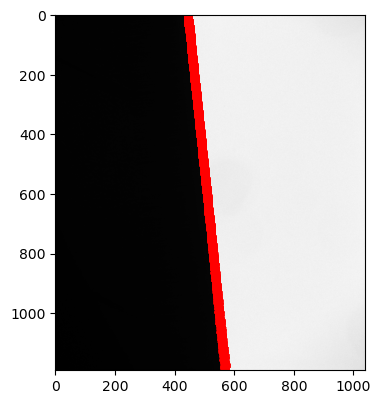

In [237]:
plt.figure(figsize=(4,5))
plt.imshow(edge,cmap='gray')
plt.plot(x,y,'rx', lw=0.1)

It is recommended to take the number of rows equal to 

In [213]:
1/np.tan(math.radians(theta))

19.081136687728208

Now we should shift the profiles so that the position of the inflection point is zero

In [218]:
rows = np.arange(30,30+19,1)#
n_rows = len(rows) #ed.shape[0]
i = 0
profile = np.zeros((n_rows,edge.shape[1]))
for row in rows:
    profile[i] = edge[row,:]
    i = i+1

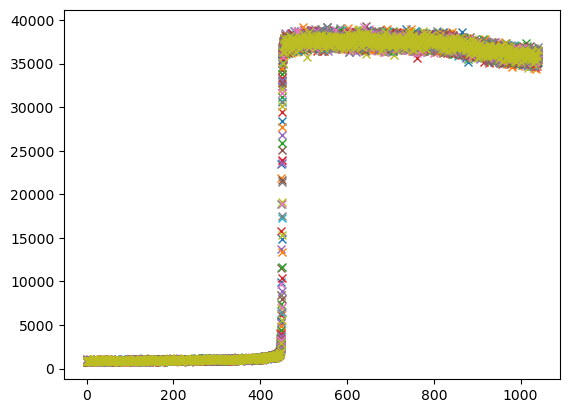

In [240]:
plt.figure()
for row in range(n_rows):
  plt.plot(profile[row],'x')

In [220]:
x = np.arange(edge.shape[1])
shifted_x =[]
Temp = []
temp =  process_limb(x,profile[0])[0]
shifted_x.append(process_limb(x,profile[0])[1])
Temp.append(temp)

In [221]:
#plt.figure(figsize=(10,10))

#shifted_x = np.zeros((n_rows,edge.shape[1]))
for row in range(1,n_rows):
 #shifted_x[row] = process_limb(x,profile[row])
  x = np.arange(edge.shape[1])
  temp =temp + np.tan(math.radians(theta)) #temp + np.tan(math.radians(theta))
  x = x - temp
  # print(temp)
  shifted_x.append(x)
  Temp.append(temp)
  #plt.axvline(x=temp)
  # print(temp)
#plt.savefig('edge_coords.png',dpi=250)

## transforming the coordinate ROF to that normal to the inclined edge

In [222]:
shifted_x = np.asarray(shifted_x)

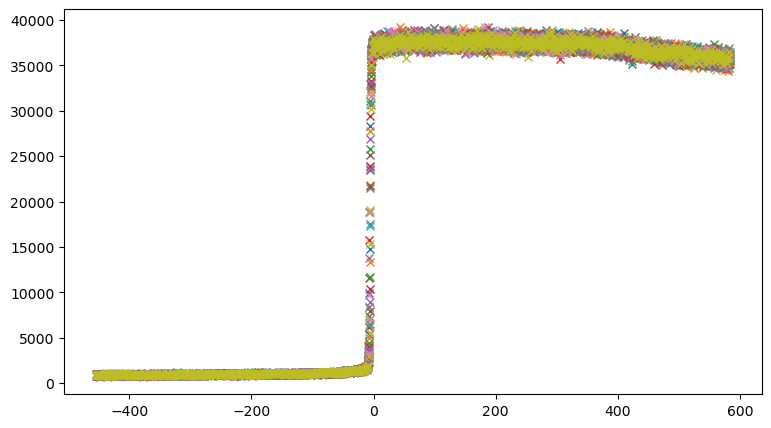

In [239]:
plt.figure(figsize=(9, 5))
for row in range(n_rows):
  plt.plot(shifted_x[row],profile[row],'x')

In [224]:
shifted_x = shifted_x*np.cos(math.radians(theta))

In [225]:
all_x, all_y = merge(shifted_x,profile)

In [226]:
# all_x, all_y = sort(all_x,all_y)
all_x = sorted(all_x)
all_y = sorted(all_y)

## Smoothing the Edge funciton

In [227]:
s_x,s_y = Lowess(all_y,all_x,1/40.)

In [228]:
esfx =s_x#all_x
esfy =s_y

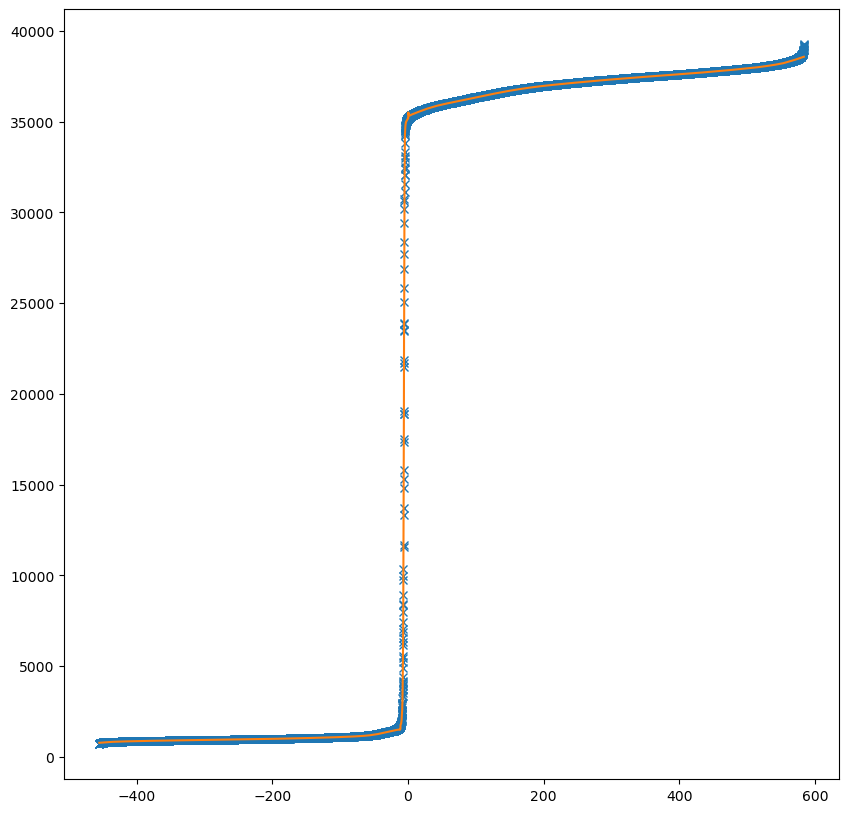

In [229]:
plt.figure(figsize=(10,10))
plt.plot(all_x,all_y,'x')
plt.plot(esfx, esfy)

## computing the LSF

In [230]:
lsfx,lsfy = compute_lsf(esfx,esfy)

## bringing the boundaries of the LSF to zero

In [231]:
lsfy2 = lsfy*np.hanning(len(lsfy))

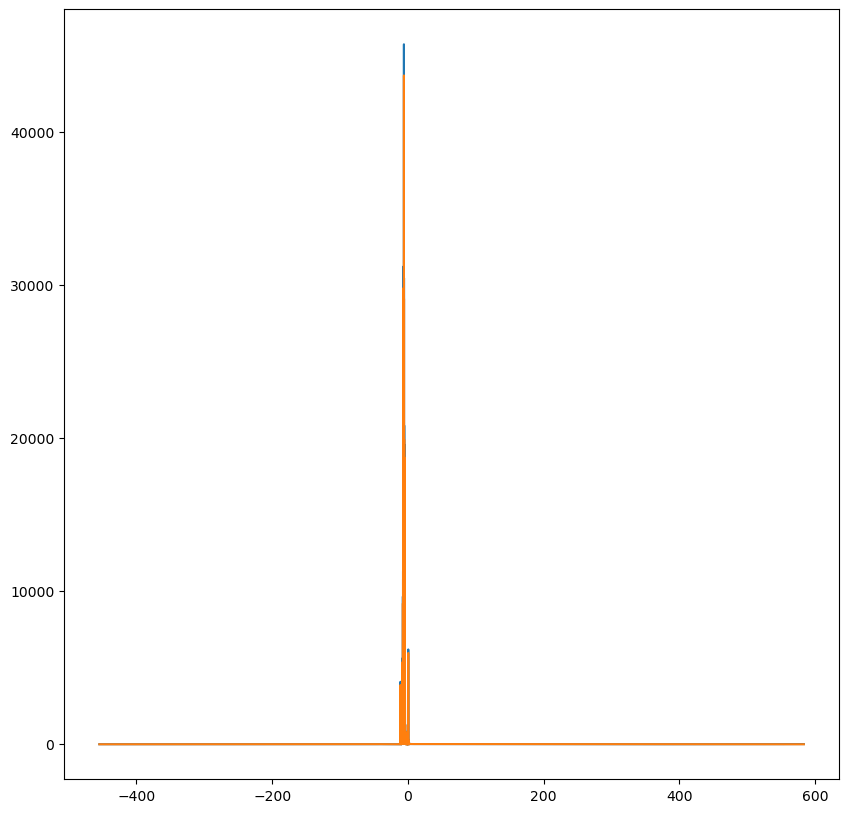

In [232]:
plt.figure(figsize=(10,10))

plt.plot(lsfx,lsfy)
plt.plot(lsfx,lsfy2)

## Computing the MTF

Text(0, 0.5, 'MTF')

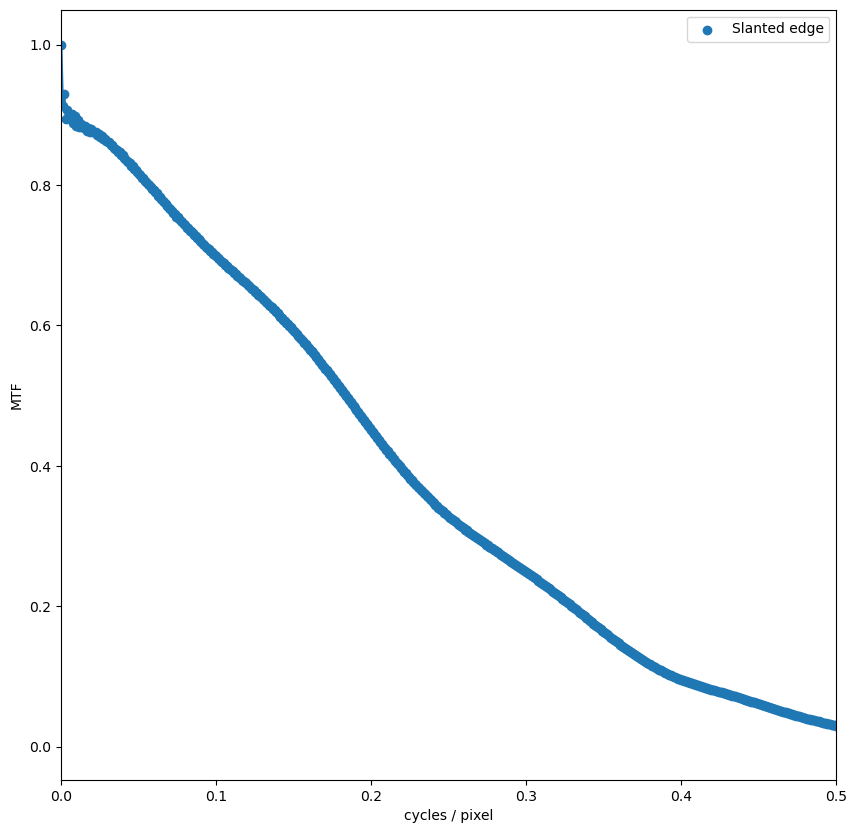

In [233]:
plt.figure(figsize=(10,10))
size = lsfx.shape[0]#edge.shape[1]
size2 = edge.shape[1]
lsf = fftshift(lsfy)
mtf = fft(lsf)
f_s = 1./19
f  = (1./(f_s*size) * np.arange(0, size, step = 1))
f2 = (1./(size2) * np.arange(0, size2, step = 1))
mtf= np.abs(mtf)
mtf = mtf/mtf.max()
mtf2 = mtf[:edge.shape[1]]
plt.plot(f[f <= n_rows / 2], mtf[f <= n_rows / 2])
plt.scatter(f2, mtf2,label='Slanted edge')
plt.xlim(0,0.5)
#plt.plot(X,Y,label='Siemens star')
plt.legend()
plt.xlabel('cycles / pixel')
plt.ylabel('MTF')
#plt.savefig('MTF.png',dpi=200)

In [44]:
def allComputeMTF(edge):
    rows = np.arange(edge.shape[0]) 
    n_rows = len(rows) 
    i = 0
    profile = np.zeros((n_rows,edge.shape[1]))
    for row in rows:
        profile[i] = edge[row,:]
        i = i+1

    coords_x = []
    coords_y = []
    x = np.arange(edge.shape[1])

    for row in range(n_rows):
        x_e,y_e = detect_edge(x,profile[row])
        coords_x.append(x_e)
        coords_y.append(row)

    x = sorted(coords_x)
    y = sorted(coords_y)

    from scipy.optimize import curve_fit
    x = np.asarray(x)
    y = np.asarray(y)
    def f(x, A, B): 
        return A*x + B
    p0 = [1,1]
    popt, pcov = scipy.optimize.curve_fit(f,x[:,0],y,p0)

    angle =np.rad2deg(np.arctan(popt[0]))

    rows = np.arange(30,30+19,1)
    n_rows = len(rows)
    i = 0
    profile = np.zeros((n_rows,edge.shape[1]))
    for row in rows:
        profile[i] = edge[row,:]
        i = i+1

    x = np.arange(edge.shape[1])
    shifted_x =[]
    Temp = []
    temp =  process_limb(x,profile[0])[0]
    shifted_x.append(process_limb(x,profile[0])[1])
    Temp.append(temp)

    for row in range(1,n_rows):
        x = np.arange(edge.shape[1])
        temp =temp + np.tan(math.radians(theta))
        x = x - temp
        shifted_x.append(x)
        Temp.append(temp)

    shifted_x = np.asarray(shifted_x)

    shifted_x = shifted_x*np.cos(math.radians(theta))

    all_x, all_y = merge(shifted_x,profile)

    all_x = sorted(all_x)
    all_y = sorted(all_y)

    s_x,s_y = Lowess(all_y,all_x,1/40.)

    esfx =s_x
    esfy =s_y

    lsfx,lsfy = compute_lsf(esfx,esfy)
    lsfy2 = lsfy*np.hanning(len(lsfy))

    # plt.figure(figsize=(10,10))
    size = lsfx.shape[0]
    size2 = edge.shape[1]
    lsf = fftshift(lsfy)
    mtf = fft(lsf)
    f_s = 1./19
    f  = (1./(f_s*size) * np.arange(0, size, step = 1))
    f2 = (1./(size2) * np.arange(0, size2, step = 1))
    mtf = np.abs(mtf)
    mtf = mtf/mtf.max()
    mtf2 = mtf[:edge.shape[1]]
    plt.plot(f[f <= n_rows / 2], mtf[f <= n_rows / 2])
    plt.scatter(f2, mtf2,label='Slanted edge')
    plt.xlim(0,0.5)
    plt.legend()
    plt.xlabel('cycles / pixel')
    plt.ylabel('MTF')
    # plt.show()


In [46]:
import numpy as np
np.arange(0, len(divided), 5)

array([ 0,  5, 10, 15, 20])

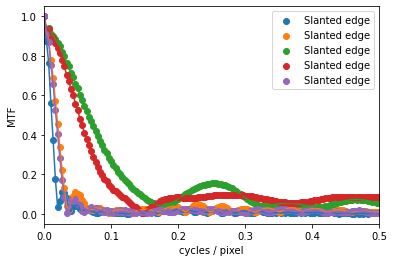

In [48]:
for i in np.arange(0, len(divided), 5):
    allComputeMTF(divided[i])
    # plt.show()